# Battle of Neighborhoods (week 2)                  
# Italian Restaurant in Toronto

Let us download all the dependencies and libraries that we need for this assignment

In [1]:
import numpy as np
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge lxml --yes  #helps in scraping the web for data


import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - lxml


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    scikit-learn-0.20.1        |   py36h22eb022_0         5.7 MB
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    liblapack-3.8.0            |      11_openblas          10 KB  conda-forge
    scipy-1.3.2                |   py36h921218d_0        18.0 MB  conda-forge
    libopenblas-0.3.6          |       h5a2b251_2         7.7 MB
    liblapacke-3.8.0           |      11_openblas          10 KB  conda-forge
    numpy-1.17.3               |   py36h95a1406_0         5.2 MB  conda-forge
    libc

<a id='item1'></a>

## 1. Introduction

### 1.1. Background and problem description:

Imagine I am a Data Science Professional working in Toronto. On a fine day, an entrepreneur comes to my office. She says that she is thinking of opening a restaurant in Toronto. She asks my help in deciding which place in Toronto would be appropriate for the restaurant so as to get a good business. I gladly offered to help her with my knowledge in data science and come up with a suitable location for her restaurant in Toronto.
                I asked the client about the category of the restaurant that she wants to set up. She said that she would like to set up an Italian restaurant. To help he, I need to find out with the help of my data science skills, which region in Toronto might be suitable for establishing an Italian restaurant so as to get a good business. Now, I need to find out external factors affecting a restaurant business and explore the neighborhoods of Toronto to find the location.
                Any person or organisation looking to set up a restaurant can following this methodology in deciding a suitable location.

## 2. Data Section
### 2.1. Description of data and the sources that will be used to solve the problem:
I need the neighborhood names in Toronto and their coordinates. For that I plan to use the Toronto neighborhood data available on Wikipedia (https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M). I can obtain the coordinates of the neighborhood location by mapping the postal codes for the neighborhoods from the CSV file that can be obtained from https://cocl.us/Geospatial_data. 
                                            Now based on the coordinates and names of the neighborhoods, I can generate a Folium Map of Toronto with the neighborhood names as pop ups. I plan to use the Foursquare API to find out the restaurant categories in each neighborhood around Toronto. Now I can cluster the neighborhoods to find out an appropriate cluster suitable for the establishment of an Italian restaurant. The cluster in which there are few Italian restaurants might serve such a purpose.


## 3. Methodology

Here we will discuss the methodology behind achieving our goal of finding a suitable region for the establishment of a Italian Restaurant in Toronto. 

### 3.1 Extracting data from a website
We are going to download and clean the Toronto neighborhoods in cells below

In [2]:
df=pd.read_html("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
df=df[0]  # Taking the dataframe with the required data
df=df[df.Borough!='Not assigned']    #ignoring the rows with the non-assigned rows
df.reset_index(inplace=True)
df.drop(columns='index', inplace=True)
df.Neighbourhood[df.Neighbourhood=='Not assigned']=df.Borough[df.Neighbourhood=='Not assigned']  #Naming the  non-assigned neighborhoods
                                                                                                #with the borough names

In [56]:
#Grouping neighborhoods with same postal codes and separting them with a comma
df_table=df.groupby(['Postcode','Borough'])['Neighbourhood'].apply(', '.join).reset_index()

df_table.columns=['PostalCode', 'Borough', 'Neighborhood']
df_table.head()


,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [4]:
shape=df_table.shape
print("The number of rows in the above dataframe is",shape[0])

The number of rows in the above dataframe is 103


<a id='item2'></a>

### 3.2 Finding out the coordinates of the neighborhoods
We will download the coordinates values based on the Postal Codes and merge them with the above table in the cells below

In [5]:
coord=pd.read_csv("https://cocl.us/Geospatial_data")  #Extracting the data from the given website
coord.set_index('Postal Code', inplace=True)
coord.head()


,Latitude,Longitude
Postal Code,,
M1B,43.806686,-79.194353
M1C,43.784535,-79.160497
M1E,43.763573,-79.188711
M1G,43.770992,-79.216917
M1H,43.773136,-79.239476


In [57]:
#Merging the coordinates data with the borough and neighborhood data

temp=coord.loc[df_table.PostalCode]
temp.reset_index(inplace=True)
temp.head()
df_table[['Latitude','Longitude']]=temp[['Latitude','Longitude']]
df_table.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


<a id='item3'></a>

### 3.3 Display of neighborhoods using Folium

We will display neighborhoods in Toronto on a map of Toronto.

In [7]:
#Separating the above dataframe such that the borough's have the word "Toronto" in them

#df_toronto=df_table[df_table['Borough'].str.find('Toronto')>0]
#df_toronto.reset_index(inplace=True)
#df_toronto=df_toronto.drop('index', axis=1)
#df_toronto.head()
df_toronto=df_table

In [58]:
#Obtaining the coordnitaes for centering the map

latitude=df_toronto['Latitude'].mean()
longitude=df_toronto['Longitude'].mean()
print('The central geographical coordinates for toronto are {}, {}.'.format(latitude, longitude))

The central geographical coordinates for toronto are 43.70460773398059, -79.39715291165048.


In [ ]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11
                        )

# add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Borough'], df_toronto['Neighborhood']):
    label = borough+": "+neighborhood   #'{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

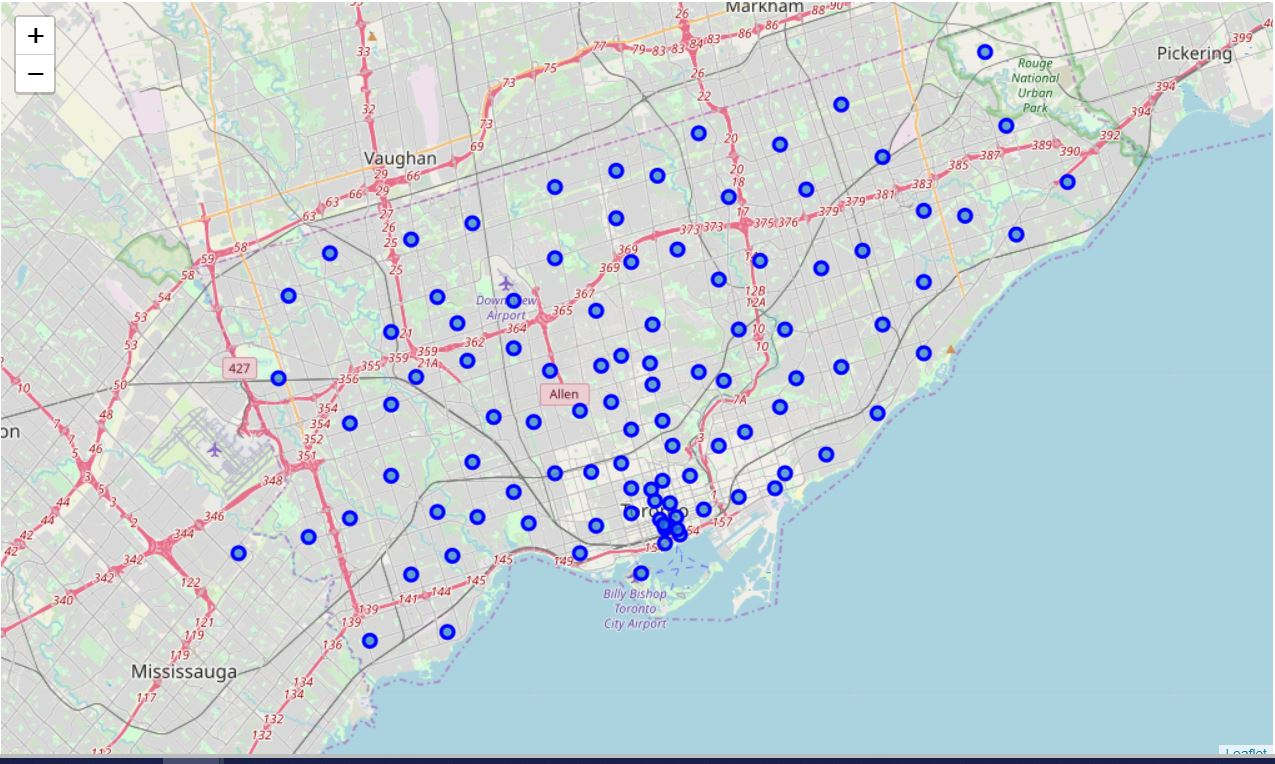

In [77]:
#Folium maps donot show on Github. Hence I am importing screenshot of the map from desktop
from IPython.display import Image
Image(filename='as_4_pic_1.JPG')

### 3.4 Using Foursquare API 

In [10]:
CLIENT_ID = 'FROUNNKNE2NFNJ3DPMSVCFHY5322WYELMEGST2E22VVQCDCN' # your Foursquare ID
CLIENT_SECRET = 'Z30WRUBMICAZU4NBL4UOTJTKB3LWTDVTRAXJU3AFIX3ONRA0' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_SECRET:' + CLIENT_SECRET)
print('CLIENT_ID: ' + CLIENT_ID)

Your credentails:
CLIENT_SECRET:Z30WRUBMICAZU4NBL4UOTJTKB3LWTDVTRAXJU3AFIX3ONRA0
CLIENT_ID: FROUNNKNE2NFNJ3DPMSVCFHY5322WYELMEGST2E22VVQCDCN


 We will explore the neighborhoods of Toronto using the Foursquare API to get venues

In [11]:
#creating a function to get the  near by venues of a given neighborhood using the Foursquare API

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [59]:
#Obtaining venues within 500m of each neighborhood with a limit of 100 venues per neighborhood
LIMIT=100
toronto_venues = getNearbyVenues(names=df_toronto['Neighborhood'],
                                   latitudes=df_toronto['Latitude'],
                                   longitudes=df_toronto['Longitude']
                                  )
toronto_venues.head()


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge, Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge, Malvern",43.806686,-79.194353,Interprovincial Group,43.805630,-79.200378,Print Shop
2,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Chris Effects Painting,43.784343,-79.163742,Construction & Landscaping
3,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
4,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Affordable Toronto Movers,43.787919,-79.162977,Moving Target


Let's separate Italian Restaurants from the information above

In [82]:
toronto_ita=toronto_venues[toronto_venues['Venue Category']=='Italian Restaurant']
toronto_ita.reset_index(inplace=True)
toronto_ita.drop(columns=['index'],inplace=True)

toronto_ita.head()


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Clarks Corners, Sullivan, Tam O'Shanter",43.781638,-79.304302,Remezzo Italian Bistro,43.778649,-79.308264,Italian Restaurant
1,"Flemingdon Park, Don Mills South",43.725900,-79.340923,Sorento Restaurant,43.726575,-79.341989,Italian Restaurant
2,"The Danforth West, Riverdale",43.679557,-79.352188,Cafe Fiorentina,43.677743,-79.350115,Italian Restaurant
3,"The Danforth West, Riverdale",43.679557,-79.352188,7 Numbers,43.677062,-79.353934,Italian Restaurant
4,"The Danforth West, Riverdale",43.679557,-79.352188,Il Fornello,43.678604,-79.346904,Italian Restaurant


### 3.5. Display of  Italian Restaurant locations on a map 

In [ ]:

map_toronto_ita = folium.Map(location=[latitude, longitude], zoom_start=12
                        )

# add markers to map
for lat, lng, venue in zip(toronto_ita['Venue Latitude'], toronto_ita['Venue Longitude'], toronto_ita['Venue']):
    label =venue   #'{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto_ita)  
    
map_toronto_ita

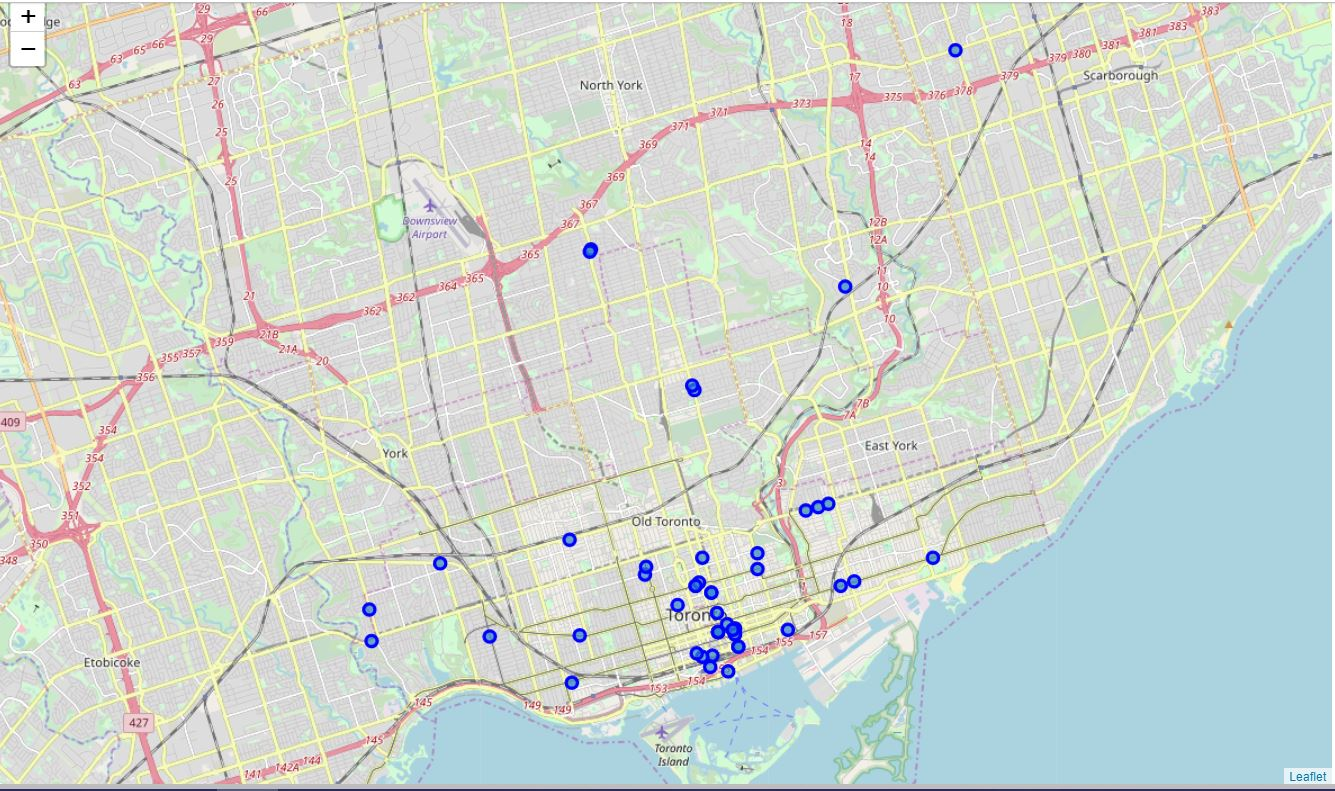

In [78]:
#Folium maps donot show on Github. Hence I am importing screenshot of the map from desktop
from IPython.display import Image
Image(filename='as_4_pic_2.JPG')

### 3.6. Clustering the Italian Restaurants
Group the Italian Restaurants into 3 clusters using KMeans Clustering. The Clustering is based on the locations of the restaurants (longitude and latitude values).

In [65]:
ita_coord=toronto_ita.loc[:][['Venue Latitude','Venue Longitude']]
ita_coord.head()


,Venue Latitude,Venue Longitude
0,43.778649,-79.308264
1,43.726575,-79.341989
2,43.677743,-79.350115
3,43.677062,-79.353934
4,43.678604,-79.346904


In [66]:
# set number of clusters
kclusters = 3



# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ita_coord)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1], dtype=int32)

In [67]:
toronto_ita.insert(0, 'Cluster Labels', kmeans.labels_)

In [73]:
t0=toronto_ita[toronto_ita['Cluster Labels']==0].shape
t1=toronto_ita[toronto_ita['Cluster Labels']==1].shape
t2=toronto_ita[toronto_ita['Cluster Labels']==2].shape
print('Italian restaurants in cluster 0 = ',t0[0])
print('Italian restaurants in cluster 1 = ',t1[0])
print('Italian restaurants in cluster 2 = ',t2[0])

Italian restaurants in cluster 0 =  7
Italian restaurants in cluster 1 =  36
Italian restaurants in cluster 2 =  6


## 4. Results 
We can use the clustering data obtained in the methodology section. 
### 4.1 Displaying the Italian Restaurants on Map after clusteirng

In [ ]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, venue, cluster in zip(toronto_ita['Venue Latitude'], toronto_ita['Venue Longitude'],toronto_ita['Venue'], toronto_ita['Cluster Labels']):
    label = folium.Popup(str(venue)+': ' + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

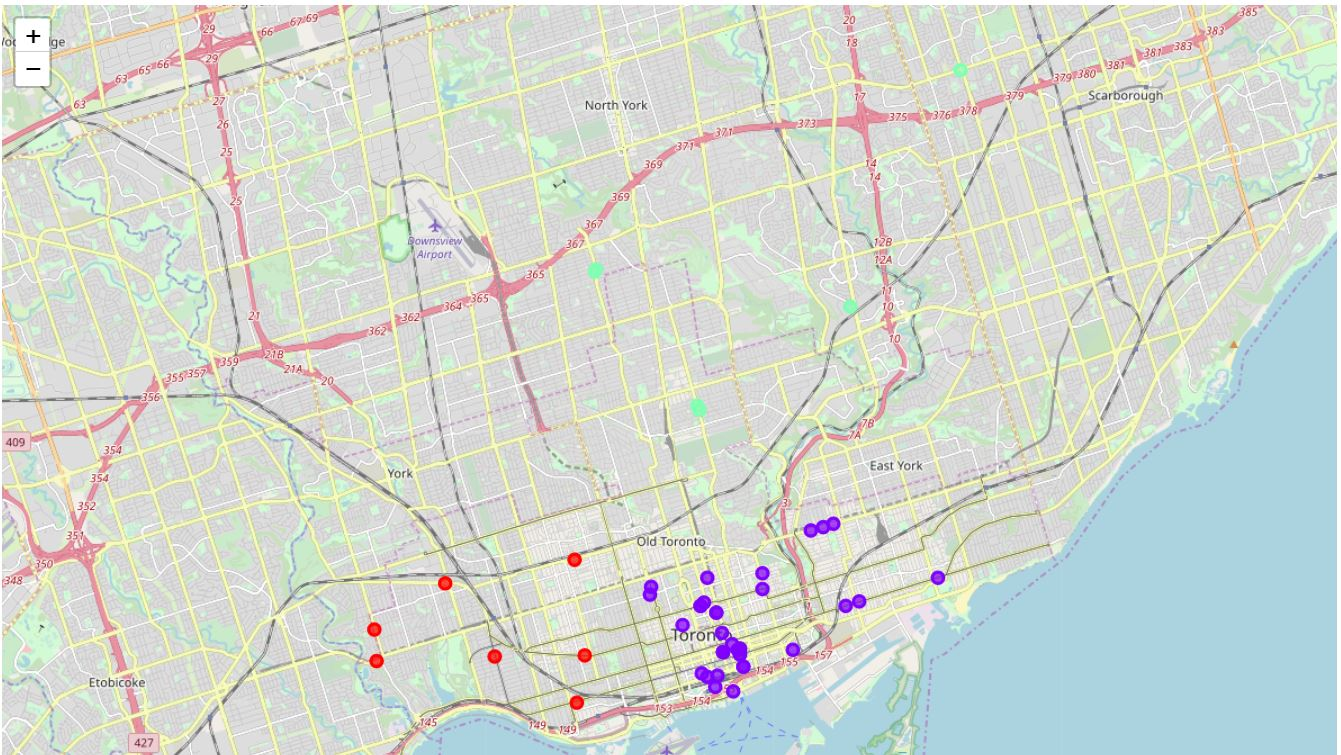

In [79]:
#Folium maps donot show on Github. Hence I am importing screenshot of the map from desktop
from IPython.display import Image
Image(filename='as_4_pic_3.JPG')

### 4.2. Applying cluster labels for neighborhoods
Now, we have to find which clusters, the neighborhoods in Toronto belong to. We are using the KMeans fit obtained from the Italian Restaurant data for the prediction.

In [48]:
clus_lab=kmeans.predict(df_toronto.loc[:][['Latitude','Longitude']])

In [49]:
df_toronto.insert(0, 'Cluster Labels', clus_lab)

In [75]:
t0=df_toronto[df_toronto['Cluster Labels']==0].shape
t1=df_toronto[df_toronto['Cluster Labels']==1].shape
t2=df_toronto[df_toronto['Cluster Labels']==2].shape
print('Neighborhoods in cluster 0 = ',t0[0])
print('Neighborhoods in cluster 1 = ',t1[0])
print('Neighborhoods in cluster 2 = ',t2[0])

Neighborhoods in cluster 0 =  34
Neighborhoods in cluster 1 =  29
Neighborhoods in cluster 2 =  40


In [ ]:
map_clusters_neighb = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, neigh, cluster in zip(df_toronto['Latitude'], df_toronto['Longitude'],df_toronto['Neighborhood'], df_toronto['Cluster Labels']):
    label = folium.Popup(str(neigh)+': ' + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters_neighb)
       
map_clusters_neighb

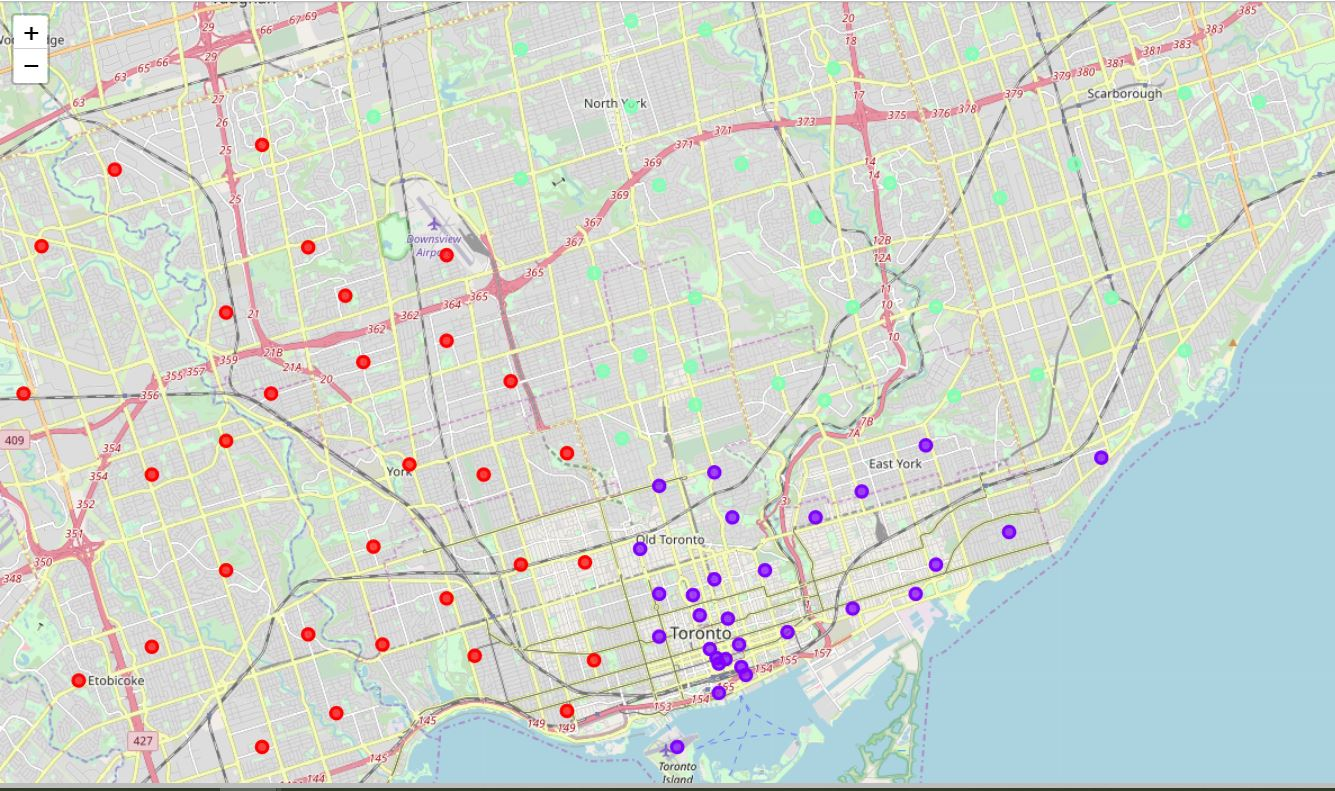

In [80]:
#Folium maps donot show on Github. Hence I am importing screenshot of the map from desktop
from IPython.display import Image
Image(filename='as_4_pic_4.JPG')

## 5. Discussion
Based on clustering analysis, there are 7 Italian Restaurants in Cluster 0, 36 in Cluster 1 and 6 in Cluster 2. When we compare neighborhoods, there are 34 in Cluster 0, 29 in Cluster 1 and 40 in Cluster 2. It can be clearly seen that cluster 2 has the least Italian Restaurants to Neighborhoods ratio. Hence, it will be a wise choice to set up an Italian Restaurant in cluster 2 to get good business. Hence Neighborhoods (green in map above) in East of Toronto are good locations for the restaurant. Those neighborhoods are displayed below.

In [76]:
df_toronto.loc[df_toronto['Cluster Labels'] == 2, ['Borough', 'Neighborhood']]

,Borough,Neighborhood
0,Scarborough,"Rouge, Malvern"
1,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,Scarborough,"Guildwood, Morningside, West Hill"
3,Scarborough,Woburn
4,Scarborough,Cedarbrae
5,Scarborough,Scarborough Village
6,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
7,Scarborough,"Clairlea, Golden Mile, Oakridge"
8,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
10,Scarborough,"Dorset Park, Scarborough Town Centre, Wexford ..."


## 6. Conclusion
We have formulated a business problem for a data science project which is in the form of a client requesting advice for location for setting up a Italian Restaurant in Toronto. We extracted data through web scraping neighborhood data in Toronto. We have used Foursquare API to explore the neighborhoods and used KMeans clustering algorithm to group various Italian Restaurants in Toronto. And we have found a suitable cluster in which the restaurant can be set up to get a decent business. 
                                                             Any audience who are interested in setting up a restaurant can use similar methodology in deciding the location for their restaurant. 